In [175]:
import sys
sys.path.append('..')

import os
import geopandas as gpd
import pandas as pd
from shapely import wkb
from geopandas import sjoin
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
import binascii
from collections import namedtuple

from shapely.geometry import Point, Polygon, MultiPolygon, MultiPoint

from sqlalchemy import create_engine, text
from sqlalchemy.exc import SQLAlchemyError

from utilities_amigocloud import AmigocloudFunctions

In [2]:
from config import RUTA_UNIDAD_ONE_DRIVE
from config import RUTA_LOCAL_ONE_DRIVE
from config import API_AMIGOCLOUD_TOKEN_ADM
from config import POSTGRES_UTEA

ID_PROYECTO = 35248
RUTA_COMPLETA = os.path.join(RUTA_UNIDAD_ONE_DRIVE, RUTA_LOCAL_ONE_DRIVE)

path_shp_cat = RUTA_UNIDAD_ONE_DRIVE + r'\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\SHP\catastro_S09_MIERCOLES.shp'

In [3]:
RUTA_COMPLETA

'G:\\OneDrive - Ingenio Azucarero Guabira S.A\\_DATOS_PYTHON'

In [4]:
ID_PROYECTO

35248

In [5]:
gdf_cat = gpd.read_file(path_shp_cat)

In [6]:
amigocloud = AmigocloudFunctions(token=API_AMIGOCLOUD_TOKEN_ADM)
amigocloud

In [9]:
#path_tif = r"C:\Users\bismarksr\Downloads\SENTINEL_2025-02-12_UTM_2.tif"
path_tif = r"C:\Users\Usuario\Downloads\SENTINEL_2025-02-12_UTM.tif"
# Cargar la imagen TIFF con rasterio
with rasterio.open(path_tif) as src:
    extent = [src.bounds.left, src.bounds.right, src.bounds.bottom, src.bounds.top]  # Límites geoespaciales
    img = src.read([1, 2, 3])  # Leer las bandas RGB

In [58]:
def obtenet_propiedades_planificadas_amigocloud():
    query = 'select distinct(unidad_01), unidad_02, unidad_03, unidad_04 from dataset_360912'
    select = amigocloud.ejecutar_query_sql(ID_PROYECTO, query, 'get')
    return select['data']

def convertir_json_a_geodataframe(json_data, nom_campo_geo):
    # Convertimos a DataFrame para manipulación tabular
    df = pd.DataFrame(json_data)
    # Convertimos la columna geometry (WKB hexadecimal) a objetos shapely
    df[nom_campo_geo] = df[nom_campo_geo].apply(lambda x: wkb.loads(bytes.fromhex(x)))
    # Creamos el GeoDataFrame en CRS original (EPSG:4326)
    gdf = gpd.GeoDataFrame(df, geometry=nom_campo_geo, crs='EPSG:4326')
    # Reproyectamos a UTM Zona 20S (EPSG:32720)
    gdf_utm20s = gdf.to_crs(epsg=32720)
    return gdf_utm20s

def obtenet_propiedad_planificada_amigocloud(unidad_01):
    query = f'select * from dataset_360912 where unidad_01 = {unidad_01}'
    select = amigocloud.ejecutar_query_sql(ID_PROYECTO, query, 'get')
    return select['data']

def obtenet_parte_diario_amigocloud(unidad_01):
    query = f'''
        SELECT pd.* FROM  dataset_367119 pd
        JOIN dataset_360912 plan
        ON ST_Intersects(pd.referencia, plan.geometry)
        WHERE plan.unidad_01 = {unidad_01}
    '''
    select = amigocloud.ejecutar_query_sql(ID_PROYECTO, query, 'get')
    return select['data']

def obtenet_paradas_amigocloud(id_parte):
    query = f'''
        select puntos.*
        from dataset_367120 puntos
        join dataset_367119 pd
        on puntos.despegue_ref_puntos = pd.amigo_id
        where pd.id = {id_parte}
    '''
    select = amigocloud.ejecutar_query_sql(ID_PROYECTO, query, 'get')
    return select['data']

def obtenet_caminos_amigocloud(cod_prop):
    query = f'''
        SELECT cam.*
        FROM dataset_373122 cam
        JOIN dataset_360912 plan
        ON ST_Intersects(cam.camino, ST_Buffer(plan.geometry, 1000))
        WHERE plan.unidad_01 = {cod_prop};
    '''
    select = amigocloud.ejecutar_query_sql(ID_PROYECTO, query, 'get')
    return select['data']

def obtenet_bitacora_amigocloud():
    query = f'''
        select * from dataset_370455
    '''
    select = amigocloud.ejecutar_query_sql(35801, query, 'get')
    return select['data']

def generar_plano_os(shp_prop, shp_plan, shp_caminos, shp_paradas, shp_bitacora, path_tif, path_out):
    # Crear el plano
    fig, ax = plt.subplots(figsize=(15, 15))
    # Mostrar la imagen de fondo (TIFF) con coordenadas georreferenciadas
    show(img, transform=src.transform, ax=ax)
    #facecolor=(R, G, B, Alpha)
    shp_prop.plot(ax=ax, edgecolor='blue', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_plan.plot(ax=ax, edgecolor='yellow', facecolor=(0, 0, 0, 0), linewidth=1)
    shp_caminos.plot(ax=ax, color='red', linewidth=2, linestyle="--", label="Líneas")
    shp_paradas.plot(ax=ax, facecolor='green', edgecolor='black', markersize=130, marker='o', linewidth=1.5)
    shp_bitacora.plot(ax=ax, facecolor='yellow', edgecolor='black', markersize=130, marker='o', linewidth=1.5)


    # Agregar etiquetas con lote mas area
    for idx, row in shp_plan.iterrows():
        if row.geometry is not None:
            label = f"{row['unidad_05']}\n{round(row['area'], 2)} ha"
            centroid = row.geometry.representative_point()  # Mejor que .centroid en algunos casos
            ax.text(centroid.x, centroid.y, label, fontsize=7, ha='center', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Etiquetas de paradas
    for idx, row in shp_paradas.iterrows():
        if row.parada is not None and 'numero' in row:
            offset = 40  # Puedes ajustar este valor según tu escala
            ax.text(row.parada.x, row.parada.y - offset, str(row['numero']),
                    fontsize=10, ha='center', va='top', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Etiquetas de paradas
    for idx, row in shp_bitacora.iterrows():
        if row.ubicacion is not None and 'tipo' in row:
            offset = 40  # Puedes ajustar este valor según tu escala
            ax.text(row.ubicacion.x, row.ubicacion.y - offset, str(row['tipo']),
                    fontsize=10, ha='center', va='top', color='black', weight=1000,
                    bbox=dict(facecolor='white', edgecolor='none', alpha=0.2, pad=0))
    
    # Configurar título
    nom_prop = shp_prop["unidad_02"].iloc[0]
    ax.set_title(nom_prop, fontsize=14)

    # 🔍 **Ajustar los límites del mapa para hacer zoom en la propiedad**
    bounds = shp_prop.total_bounds  # [xmin, ymin, xmax, ymax]
    ax.set_xlim([bounds[0] - 400, bounds[2] + 400])
    ax.set_ylim([bounds[1] - 400, bounds[3] + 400])
    # 🔹 **Agregar Leyenda**
    legend_elements = [
        #facecolor=(R, G, B, Alpha)
        Patch(facecolor=(0, 0, 0, 0), edgecolor='blue', label='Lotes Propiedad'),
        Patch(facecolor=(0, 0, 0, 0), edgecolor='yellow', label='Lotes Aplicar'),
        # Líneas (Caminos, canales, etc.)
        Line2D([0], [0], color='red', linewidth=1, linestyle="-", label='Caminos'),
        Line2D([0], [0], marker='o', color='black', markerfacecolor='green', markeredgewidth=1,
               label='Paradas', linestyle='', markersize=10),
        Line2D([0], [0], marker='o', color='black', markerfacecolor='yellow', markeredgewidth=1,
               label='Ubicaciones', linestyle='', markersize=10),
    ]
    ax.legend(handles=legend_elements, loc='upper right', fontsize=10, frameon=True, facecolor='white', edgecolor='black')

    # Guardar plano
    fig.savefig(path_plano, dpi = 300, bbox_inches='tight')
    
    # Mostrar el mapa
    #plt.show()

In [11]:
df_props = pd.DataFrame(obtenet_propiedades_planificadas_amigocloud())
df_props

,unidad_01,unidad_02,unidad_03,unidad_04
0,375,SANTA ANITA--GUILLERMO SANTIAGO,18027,AGUILERA TARRADELLES GUILLERMO
1,220,SANTA BARBARA--CRONENBOLD ROBERTO,2641,CRONENBOLD AGUILERA ROBERTO


In [123]:
for i, row in df_props.iterrows():
    print(row['unidad_01'])
    print(row['unidad_02'])

375
SANTA ANITA--GUILLERMO SANTIAGO
220
SANTA BARBARA--CRONENBOLD ROBERTO


In [13]:
cod_prop = 375

In [124]:
nom_prop = 'SANTA ANITA'

In [14]:
# obtener propiedad desde amigocloud
lotes_planificacion = obtenet_propiedad_planificada_amigocloud(cod_prop)
# convertir a gdf
gdf_lotes_planificacion = convertir_json_a_geodataframe(lotes_planificacion, 'geometry')

In [159]:
# obtener parte diario desde amigocloud
parte_diario = obtenet_parte_diario_amigocloud(cod_prop)
# convertir parte diario a gdf
gdf_parte_diario = convertir_json_a_geodataframe(parte_diario, 'referencia')

In [160]:
# error
if len(gdf_parte_diario) > 1:
    print(f'Error, propiedad: {cod_prop} tiene mas de un parte diario')

In [167]:
# id de parte diario
id_parte_diario = gdf_parte_diario['id'].iloc[0]
# id de mezcla
id_mezcla = gdf_parte_diario.iloc[0]['mezcla']

In [20]:
# obtener paradas de dron y convertir a gdf
paradas = obtenet_paradas_amigocloud(id_parte_diario)
gdf_paradas = convertir_json_a_geodataframe(paradas, 'parada')

In [23]:
# otener caminos y convertir a gdf
caminos = obtenet_caminos_amigocloud(cod_prop)
gdf_caminos = convertir_json_a_geodataframe(caminos, 'camino')

In [55]:
# optener bitacora y convertir a gdf
bitacora = obtenet_bitacora_amigocloud()
gdf_bitacora = convertir_json_a_geodataframe(bitacora, 'ubicacion')
# convierte bitacora a puntos individuales
gdf_bitacora = gdf_bitacora.explode(index_parts=False).reset_index(drop=True)

In [27]:
path_plano = RUTA_COMPLETA + r"\planos\plano_aux_os.jpg"

In [28]:
prop = gdf_cat[gdf_cat['unidad_01'] == cod_prop]

In [70]:
# Unir todos los polígonos de propiedad en uno solo
prop_union = prop.unary_union
# Crear un solo buffer de 1000m alrededor de ala propiedad
buffer_union = prop_union.buffer(1000)
# Convertir a GeoDataFrame
gdf_buffer_union = gpd.GeoDataFrame(geometry=[buffer_union], crs=prop.crs)

In [71]:
# intersectar buffer de propiedad con puntos individuales de bitacora
gdf_bitacora_cercanos = gpd.sjoin(
    gdf_bitacora, gdf_buffer_union, predicate='intersects', how='inner'
)

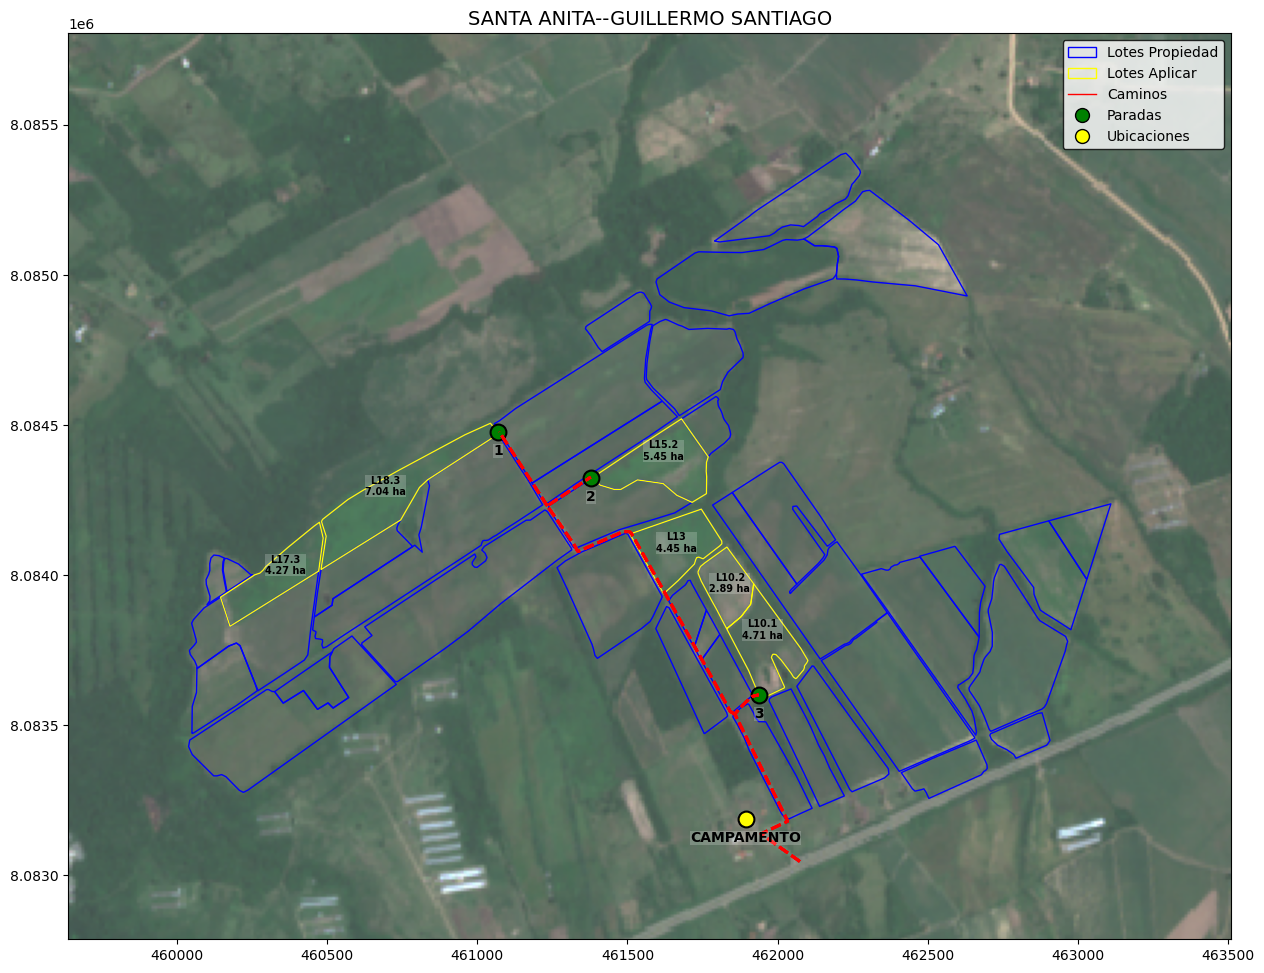

In [73]:
generar_plano_os(prop, gdf_lotes_planificacion, gdf_caminos, gdf_paradas, gdf_bitacora_cercanos, path_tif, path_plano)

In [79]:
PATH_PLAN_XLSX = RUTA_UNIDAD_ONE_DRIVE + r"\Ingenio Azucarero Guabira S.A\UTEA - SEMANAL - EQUIPO AVIACION UTEA\Pulverizacion\2025\pd_pulverizacion_2025.xlsx"

In [115]:
df_calidad_agua = pd.read_excel(PATH_PLAN_XLSX, sheet_name="CALIDAD_AGUA")
prop_calidad = df_calidad_agua[df_calidad_agua['UNIDAD_01'] == cod_prop]
ph = prop_calidad.iloc[0]['PH']
dureza = prop_calidad.iloc[0]['DUREZA (mg/l)']

In [121]:
df_planificacion = pd.read_excel(PATH_PLAN_XLSX, sheet_name="PROGRAMACION")
prop_mapeo = df_planificacion[df_planificacion['UNIDAD_01'] == cod_prop]
area_mapeo = prop_mapeo.iloc[0]['AREA MAPEO']
fecha_apli = prop_mapeo.iloc[0]['FECHA']
fecha_apli = fecha_apli.strftime('%d/%m/%Y')

In [169]:
df_mezcla = pd.read_excel(PATH_PLAN_XLSX, sheet_name="MEZCLAS")

In [170]:
df_mezcla

,N°,ORDEN DE MEZCLA,NOMBRE COMERCIAL,INGREDIENTE ACTIVO,CATEGORIA,DOSIS,UM
0,1,NaN,KFOL,FOSFORO,MADURANTE,2,kg/ha
1,1,NaN,TA35,CLORATO DE SODIO,COADYUVANTE,0.05,lt/ha
2,2,NaN,KFOL,FOSFORO,MADURANTE,2,kg/ha
3,2,NaN,TWIN PLUS,NONIL FENOL ETOXILADO,COADYUVANTE,0.05,lt/ha
4,3,NaN,SUMO,CLORANTRANIPROLE,INSECTICIDA,0.1,lt/ha
...,...,...,...,...,...,...,...
145,46,NaN,MODDUS,TRINEXAPAC ETILO,MADURANTE,1,lt/ha
146,46,NaN,PROTEMAX ATR,NaN,MADURANTE,2,lt/ha
147,46,NaN,DRIVE,ALCOHOL ETOXILADO LINEAL,COADYUVANTE,0.1,lt/ha
148,47,2.0,CIPRIAN,TRINEXAPAQUE-ETILICO,MADURANTE,1,lt/ha


In [184]:
mezcla = df_mezcla[df_mezcla['N°'] == id_mezcla]

In [185]:
mezcla = mezcla.sort_values(by='ORDEN DE MEZCLA')
mezcla['ORDEN DE MEZCLA'] = mezcla['ORDEN DE MEZCLA'].astype(int)

In [186]:
mezcla.columns = (
    mezcla.columns
    .str.lower()            # minúsculas
    .str.strip()            # eliminar espacios al inicio/fin
    .str.replace(r'\W+', '_', regex=True)  # reemplazar no alfanuméricos por "_"
    .str.replace(r'_+', '_', regex=True)   # reducir múltiple "_" a uno
)

In [187]:
mezcla

,n_,orden_de_mezcla,nombre_comercial,ingrediente_activo,categoria,dosis,um
149,47,1,IMPRO FULL PLUS,NONIL FENOL ETOXILADO,COADYUVANTE,0.1,lt/ha
148,47,2,CIPRIAN,TRINEXAPAQUE-ETILICO,MADURANTE,1,lt/ha


In [188]:
# Crear la clase con los nombres de columnas
Mezcla = namedtuple("Mezcla", mezcla.columns)
# Convertir cada fila en un objeto
lista_mezclas = [Mezcla(*fila) for fila in mezcla.to_numpy()]

In [189]:
lista_mezclas

[Mezcla(n_=47, orden_de_mezcla=1, nombre_comercial='IMPRO FULL PLUS', ingrediente_activo='NONIL FENOL ETOXILADO', categoria='COADYUVANTE', dosis=0.1, um='lt/ha'),
 Mezcla(n_=47, orden_de_mezcla=2, nombre_comercial='CIPRIAN', ingrediente_activo='TRINEXAPAQUE-ETILICO', categoria='MADURANTE', dosis=1, um='lt/ha')]